In [1]:
from lasso import *
from numpy import savez, load, random, concatenate, linspace
from tqdm.notebook import tqdm
from os import makedirs; makedirs('images', exist_ok=True); makedirs('videos', exist_ok=True)
from os.path import join
import warnings
warnings.filterwarnings("ignore", message='Adding an axes using the same arguments as a previous axes')

VID = True

%matplotlib notebook
from matplotlib.pyplot import legend, figure as mpl_figure, close, savefig, rcParams, subplot, plot, gca, tight_layout

rcParams['figure.figsize'] = [9.5, 6]
def figure(name, *args, **kwargs):
    close(name); f = mpl_figure(name, *args, **kwargs);return f

def type2str(T):
    if T is True:
        return 'adaptive'
    elif T is False:
        return 'fixed'
    else:
        return T

def opt2vid(isFEM, iters, ker, alg=None):
    if VID:
        if alg is None:
            alg = type2str(isFEM[1])
        else:
            alg = alg.replace(' ','_').replace(',','_').replace('(','').replace(')','').replace('__','_')
        return {'filename':join('videos','lasso_vid_'+ker+'_' + alg +'_'+ str(isFEM[0])),
               'fps':int(log(iters[0]) / log(iters[1]) / 30) + 1}
    else:
        return None

COLORS = rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
%matplotlib notebook

In [3]:
try:
    with load(join('data','lasso_arrays.npz'), allow_pickle=True) as tmp:
        results = tmp['results'].item(0).copy()
except Exception:
    results = {}
            
def set_result(recon, record, isFEM, iters, ker, name=None):
    arr = record.extras.T.copy()
    arr[7:9] = 1-arr[7:9]
    record.I[0] = 1
    key = (('Gaussian' if ker[0]=='G' else 'Fourier',)
           +tuple(iters)+tuple(isFEM)
           +(str(name),))
    results[key] = recon, record.I, record.T, arr
    return recon, record.I, record.T, arr

def Result(isFEM=None, iters=None, ker='F', name=None):
    s = 'Gaussian' if ker[0]=='G' else 'Fourier'
    check = [(0,s)]
    if iters is not None:
        if isscalar(iters):
            check.append((1,iters))
        else:
            check.append((1,iters[0]))
            check.append((2,iters[1]))
    if isFEM is not None:
        if isscalar(iters):
            check.append((3,isFEM))
        else:
            check.append((3,isFEM[0]))
            check.append((4,isFEM[1]))
    if name is not None:
        check.append((5,str(name)))
        
    sublist = [r for r in results 
               if all(r[k]==v for k,v in check)]
    if len(sublist) == 0:
        return None
    elif len(sublist) == 1:
        return results[sublist[0]]
    else:
        return [results[r] for r in sublist]

labels = ['continuous gap', 'discrete gap', 'E', 
          'E^* continuous', 'E^* discrete', 
          'pixel size', 'number of pixels',
          'continuous threshold', 'discrete threshold',
         ] # These are the descriptions of rows of 'record' where used
style = ['m-','m--','g-.','g-','g--','b--','b-','r-','r--',
        'k--','k-.','k:']

def best_fit(x,y,rate,shift=25):
    x = x**(-float(rate))
    scale = max(1e-8/x.min(), (y/x).max()/shift)
    return scale * x

def set_axes(ax, I):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left=1, right=I)
    ax.set_ylim(bottom=1e-6, top=1e3)
    ax.grid(True, 'major', 'both')
    
def mid(x): return x[len(x)//6:-len(x)//6]


short_iters, long_iters, bigdof = (int(1e5),1.1), (int(1e6),1.1), 1000

# Initialise examples

In [4]:
random.seed(1)
dim, peaks = 1, 10 # The ground-truth has <peaks> spikes in <dim> dimensions

# The ground-truth has <peaks> spikes
gt_measure = array(concatenate([3 * random.randn(peaks, 1), .1 + .8 * random.rand(peaks, dim)], axis=1))

points = {
    # We sample 30 Fourier frequencies uniformly in [-100, 100].
    'Fourier':100 * 2 * (random.rand(30, dim) - .5),
    # 30 uniformly spaced Gaussian kernels.
    'Gaussian':linspace(0,1,30)
}

# Clean data
A = {
    'Fourier': kernelMap1D(ker='Fourier', x=points['Fourier'], Norm=1.271),
    'Gaussian': kernelMap1D(ker='Gaussian', x=points['Gaussian'], sigma=0.12, Norm=5.140)
}
data = {s:k * gt_measure for s,k in A.items()}

# Noisy data
noise = 0
data = {s:d+noise * abs(d).max() * random.randn(*d.shape) for s,d in data.items()}

weight = {'Fourier':0.02, 'Gaussian':0.06}

# Run all examples

In [5]:
short_runs = [(ndofs,adaptive) for ndofs in (128,256,512) for adaptive in (True,False,'CBP')]
long_runs = [(adaptive,alg,name+(' (adaptive)' if adaptive else '')) 
             for adaptive in (True,False) for alg,name in [
                 ('Greedy','Greedy FISTA'), 
                 (('FB',{'scale':2}), 'FB'),
                 (('FISTA',{'a':2}), 'FISTA, a=2'),
                 (('FISTA',{'a':20}), 'FISTA, a=20'),
                 (('FISTA',{'a':2, 'restarting':True}), 'Restarting FISTA, a=2'),
             ]] + [('CBP',None, 'CBP')]
names = 'Greedy FISTA', 'FISTA, a=20'

In [6]:
for ker in tqdm(('Fourier', 'Gaussian'),desc='Kernel',smoothing=0):
    iters = short_iters
    for isFEM in tqdm(short_runs,desc='Short runs %s'%ker,smoothing=0):
        if Result(isFEM, iters, ker) is not None:
            continue
        if isFEM[1]=='CBP':
            recon, record = CBP(A[ker], data[ker], weight[ker], isFEM, iters,
                                        plot=({'color':'black'} if VID else False), 
                                        vid=opt2vid(isFEM,iters,ker), prnt=False, algorithm=('FISTA',{'a':20}))
        else:
            recon, record = Lasso(A[ker], data[ker], weight[ker], isFEM, iters,
                                        plot=({'color':'black'} if VID else False), 
                                        vid=opt2vid(isFEM,iters,ker), prnt=False, algorithm=('FISTA',{'a':20}))

        set_result(recon, record, isFEM, iters, ker)

    ndofs, iters = bigdof, long_iters
    for adaptive,alg,name in tqdm(long_runs,desc='Long runs %s'%ker,smoothing=0):
        isFEM = (ndofs,adaptive)
        if Result(isFEM, iters, ker, name) is not None:
            continue
        if adaptive=='CBP':
            recon, record = CBP(A[ker], data[ker], weight[ker], isFEM, iters,
                                        plot=({'color':'black'} if VID else False), 
                                        vid=opt2vid(isFEM,iters,ker,name), prnt=False)
        else:
            recon, record = Lasso(A[ker], data[ker], weight[ker], isFEM, iters,
                                        plot=({'color':'black'} if VID else False), 
                                        vid=opt2vid(isFEM,iters,ker,name), prnt=False, algorithm=alg)
        set_result(recon, record, isFEM, iters, ker, name)


savez(join('data','lasso_arrays.npz'), results={k:(None,)+v[1:] for k,v in results.items()})

# Plotting
## Short Runs

In [7]:
%matplotlib notebook

<IPython.core.display.Javascript object>


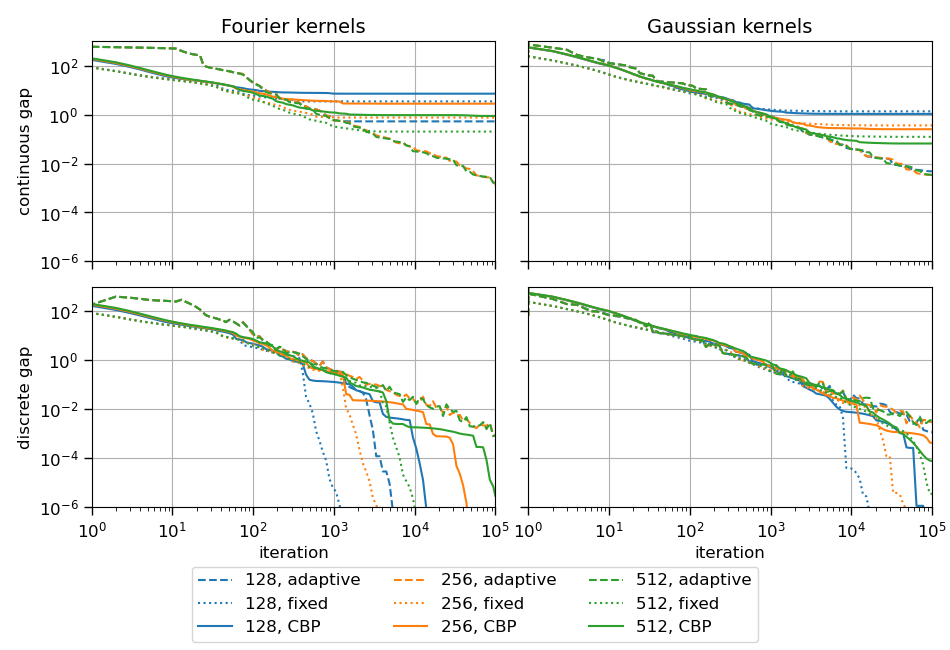

Total numbers of pixels: 	130.0	212.0	210.0	131.0	140.0	140.0	

In [8]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = figure('ndofs comparison', figsize=(9.5,6.5))
ax = fig.subplots(2,2,sharex='all',sharey='all')
print('Total numbers of pixels: ', end='\t')
for I,ker in enumerate(('Fourier','Gaussian')):
    labels = []
    for ndofs, adaptive in short_runs:
        c = COLORS[[128,256,512].index(ndofs)]
        s = ('dashed','dotted','solid')[[True,False,'CBP'].index(adaptive)]
        recon, i, t, record = Result((ndofs,adaptive), short_iters, ker)
        ax[0,I].plot(i, record[0], color=c, linestyle=s)
        labels.append(('%d, '%ndofs) + type2str(adaptive))
        ax[1,I].plot(i, record[1], color=c, linestyle=s)
        if adaptive is True:
            print(record[6].max(), end='\t')
    for a in ax[:,I]:
        a.tick_params(length=6, width=1, which='major')
        a.tick_params(length=3, which='minor')
        set_axes(a, short_iters[0]);
    ax[0,I].set_title('%s kernels'%ker); ax[1,I].set_xlabel('iteration'); 
ax[0,0].set_ylabel('continuous gap'); ax[1,0].set_ylabel('discrete gap')
fig.legend(labels,loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.22)
savefig(join('images','lasso_ndofs_convergence.png'), dpi=300)

## Long Comparisons

<IPython.core.display.Javascript object>


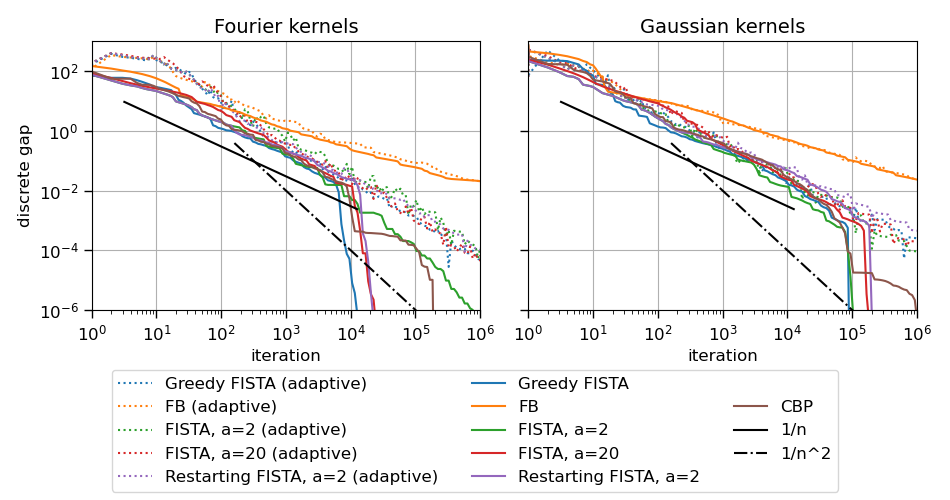

In [9]:
colors = COLORS.copy()
colors = {k:colors.pop(0) for _,__,k in long_runs if 'adaptive' not in k}

fig = figure('Comparison', figsize=(9.5,5));
ax = fig.subplots(ncols=2,sharex='all',sharey='all')
for I,ker in enumerate(('Fourier', 'Gaussian')):
    for adaptive,alg,name in long_runs:
        recon, i, t, record = Result((bigdof,adaptive), long_iters, ker, name)
#         plot(i, record[0], linestyle='dashed', label=name) # Continuous gap
        if I==0 and name=='CBP':
            ax[0].plot([0],alpha=0,label=' ')
        ax[I].plot(i, record[1], 
             color=colors[name.replace(' (adaptive)','')],
             linestyle='dotted' if 'adaptive' in name else '-', 
             label=name if I==0 else None) # Discrete gap
    ax[I].plot(mid(i)/10, 300/mid(i), 'k-', label='1/n' if I==0 else None)
    ax[I].plot(mid(i)*5, (20/mid(i))**2, 'k-.', label='1/n^2' if I==0 else None)
    set_axes(ax[I], long_iters[0]); ax[I].set_title('%s kernels'%ker)
    ax[I].tick_params(length=6, width=1, which='major')
    ax[I].tick_params(length=3, which='minor')
    ax[I].set_xlabel('iteration'); 
ax[0].set_ylabel('discrete gap')
fig.legend(loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.38)
savefig(join('images','lasso_convergence.png'), dpi=300)

<IPython.core.display.Javascript object>


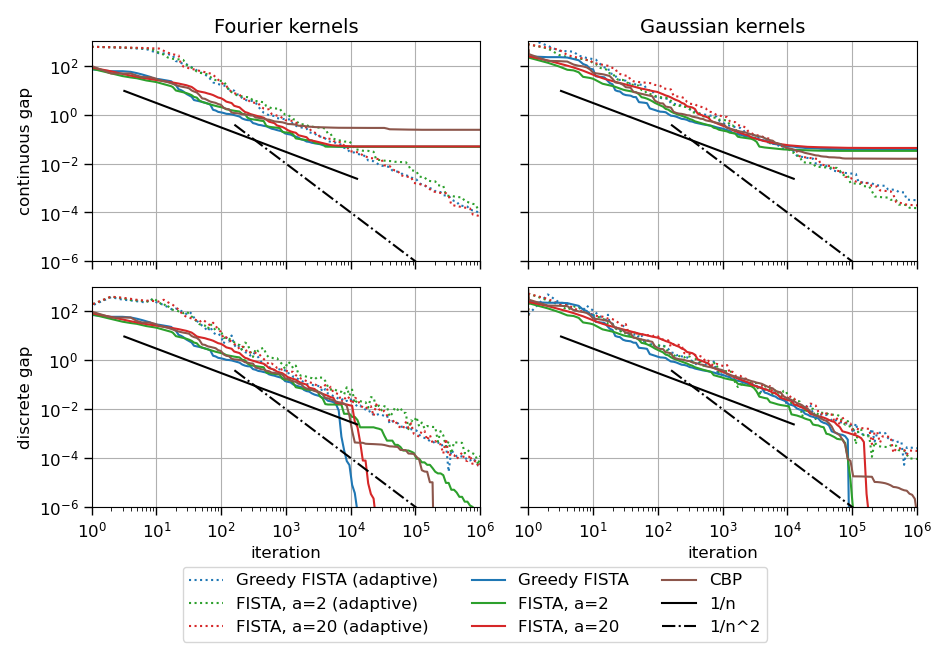

In [10]:
colors = COLORS.copy()
colors = {k:colors.pop(0) for _,__,k in long_runs if 'adaptive' not in k}

## This plots both gaps
fig = figure('Comparison short', figsize=(9.5,6.5));
ax = fig.subplots(2,2,sharex='all',sharey='all')
for I,ker in enumerate(('Fourier','Gaussian')):
    for adaptive,alg,name in long_runs:
        if any(name.startswith(s) for s in ('FB','Restart')):
            continue
        recon, i, t, record = Result((bigdof,adaptive), long_iters, ker, name)
        ax[0,I].plot(i, record[0],
             color=colors[name.replace(' (adaptive)','')],
             linestyle='dotted' if 'adaptive' in name else '-', 
             label=name if I==0 else None) # continuous gap
        ax[1,I].plot(i, record[1], 
             color=colors[name.replace(' (adaptive)','')],
             linestyle='dotted' if 'adaptive' in name else '-') # Discrete gap
    for a in ax[:,I]:
        a.plot(mid(i)/10, 300/mid(i), 'k-', label='1/n' if I==0 and a!=ax[0,I] else None)
        a.plot(mid(i)*5, (20/mid(i))**2, 'k-.', label='1/n^2' if I==0 and a!=ax[0,I] else None)
        set_axes(a, long_iters[0])
        a.tick_params(length=6, width=1, which='major')
        a.tick_params(length=3, which='minor')
    ax[0,I].set_title('%s kernels'%ker); ax[1,I].set_xlabel('iteration'); 
ax[0,0].set_ylabel('continuous gap'); ax[1,0].set_ylabel('discrete gap')
fig.legend(loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.22)

## This just plots discrete gaps
# fig = figure('Comparison short', figsize=(9.5,4.5));
# ax = fig.subplots(ncols=2,sharex='all',sharey='all')
# for I,ker in enumerate(('Fourier', 'Gaussian')):
#     for adaptive,alg,name in long_runs:
#         if any(name.startswith(s) for s in ('FB','Restart')):
#             continue
#         recon, i, t, record = Result((bigdof,adaptive), long_iters, ker, name)
#         ax[I].plot(i, record[1], 
#              color=colors[name.replace(' (adaptive)','')],
#              linestyle='dotted' if 'adaptive' in name else '-', 
#              label=name if I==0 else None) # Discrete gap
#     ax[I].plot(mid(i)/10, 300/mid(i), 'k-', label='1/n' if I==0 else None)
#     ax[I].plot(mid(i)*5, (20/mid(i))**2, 'k-.', label='1/n^2' if I==0 else None)
#     set_axes(ax[I], long_iters[0]); ax[I].set_title('%s kernels'%ker)
#     ax[I].tick_params(length=6, width=1, which='major')
#     ax[I].tick_params(length=3, which='minor')
#     ax[I].set_xlabel('iteration'); 
# ax[0].set_ylabel('discrete gap')
# fig.legend(loc='lower center', ncol=3)
# tight_layout()
# fig.subplots_adjust(bottom=0.32)

savefig(join('images','lasso_convergence_short.png'), dpi=300)

## Long with zoom

<IPython.core.display.Javascript object>


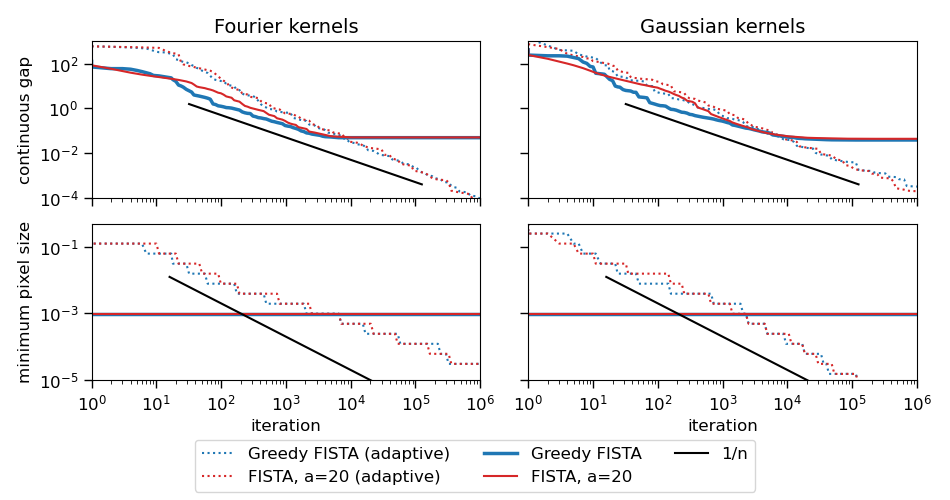

In [11]:
fig = figure('adaptive comparison', figsize=(9.5,5))
ax = fig.subplots(2,2,sharex='all',sharey='row', subplot_kw={'xscale':'log','yscale':'log'})
for I,ker in enumerate(('Fourier', 'Gaussian')):
    for adaptive,alg,name in long_runs:
        if name.replace(' (adaptive)','') not in names:
            continue
        recon, i, t, record = Result((bigdof,adaptive), long_iters, ker, name)
        ax[0,I].plot(i, record[0], color=colors[name.replace(' (adaptive)','')],
             linestyle='dotted' if 'adaptive' in name else '-',
             linewidth=1.5 if (names[1] in name) or ('adaptive' in name) else 2.5,
             label=name if I==0 else None) # Continuous gap
        ax[1,I].plot(i, record[5], color=colors[name.replace(' (adaptive)','')],
             linestyle='dotted' if 'adaptive' in name else '-', 
             linewidth=1.5 if (names[1] in name) or ('adaptive' in name) else 2.5) # Pixel size

    ax[0,I].plot(mid(i), 50/mid(i), 'k-', label='1/n' if I==0 else None)
    ax[1,I].plot(mid(i)/2, .4/mid(i), 'k-')
    for a in ax[:,I]:
        a.tick_params(length=6, width=1, which='major')
        a.tick_params(length=3, which='minor')
    a = ax[0,I]; a.set_xlim(1,long_iters[0]); a.set_ylim(1e-4,1e3)
    a.set_title('%s kernels'%ker);
    a = ax[1,I]; a.set_xlim(1,long_iters[0]); a.set_ylim(1e-5,.5)
    a.set_xlabel('iteration'); 
    ax[0,0].set_ylabel('continuous gap'); ax[1,0].set_ylabel('minimum pixel size')

fig.legend(loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.24) 
savefig(join('images','lasso_reduced_convergence.png'), dpi=300)

## Long with time

<IPython.core.display.Javascript object>


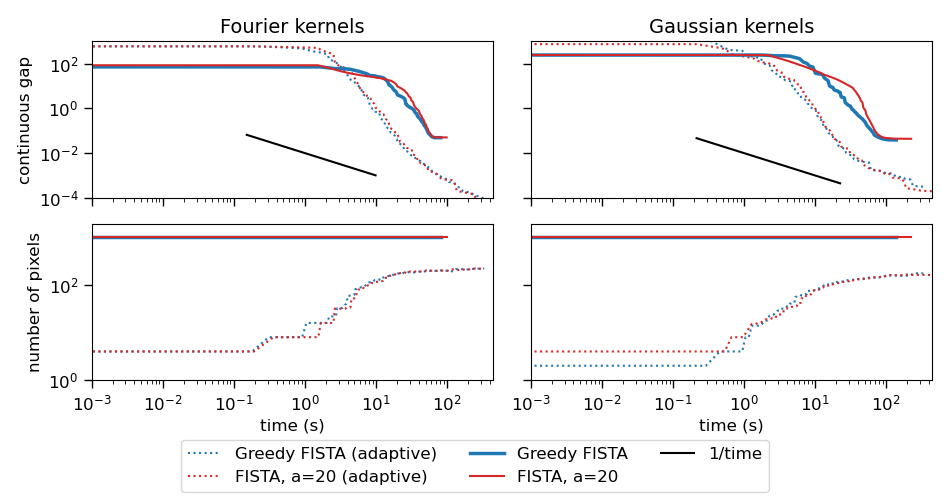

In [12]:
fig = figure('adaptive comparison time', figsize=(9.5,5))
ax = fig.subplots(2,2,sharex='all',sharey='row', subplot_kw={'xscale':'log','yscale':'log'})
for I,ker in enumerate(('Fourier', 'Gaussian')):
    T = 0
    for adaptive,alg,name in long_runs:
        if name.replace(' (adaptive)','') not in names:
            continue
        recon, i, t, record = Result((bigdof,adaptive), long_iters, ker, name)
        T = max(T,t.max())
        ax[0,I].plot(t, record[0], color=colors[name.replace(' (adaptive)','')],
             linestyle='dotted' if 'adaptive' in name else '-',
             linewidth=1.5 if (names[1] in name) or ('adaptive' in name) else 2.5,
             label=name if I==0 else None) # Continuous gap
        ax[1,I].plot(t, record[6], color=colors[name.replace(' (adaptive)','')],
             linestyle='dotted' if 'adaptive' in name else '-', 
             linewidth=1.5 if (names[1] in name) or ('adaptive' in name) else 2.5) # pixel size/count

    ax[0,I].plot(t[1:]/10, .1/t[1:], 'k-', label='1/time' if I==0 else None)
    for a in ax[:,I]:
        a.tick_params(length=6, width=1, which='major')
        a.tick_params(length=3, which='minor')
    a = ax[0,I]; a.set_xlim(1e-3,T); a.set_ylim(1e-4,1e3);
    a.set_title('%s kernels'%ker);
    a = ax[1,I]; a.set_xlim(1e-3,T); a.set_ylim(1,2e3);
    a.set_xlabel('time (s)'); 
    ax[0,0].set_ylabel('continuous gap'); ax[1,0].set_ylabel('number of pixels')
fig.legend(loc='lower center', ncol=3)
tight_layout()
fig.subplots_adjust(bottom=0.24) 
savefig(join('images','lasso_convergence_time.png'), dpi=300)